In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn import  linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
malware=pd.read_csv('/content/drive/MyDrive/malware-detection-va/train.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
target=malware['HasDetections']
malware

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,6ca9b92a49d4d23fc4754d464155cbb1,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1516.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,154,108573.0,27.0,240.0,233,windows10,x86,10.0.0.0,17134,256,rs4,17134.1.x86fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,1980.0,317708.0,2.0,5.0,...,HDD,476043.0,0,4096.0,Desktop,15.7,1280.0,800.0,Desktop,NaN,4.294967e+09,10.0.17134.228,x86,rs4_release,17134,228,Professional,PROFESSIONAL,Upgrade,9.0,34,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,33778.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,640b82f0a7bd3701818b9442d1432937,win8defender,1.1.15200.1,4.18.1807.18075,1.275.727.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,39,64466.0,NaN,15.0,58,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,1915.0,225063.0,4.0,5.0,...,SSD,237673.0,0,8192.0,Desktop,65.0,1920.0,1080.0,Mobile,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,Reset,8.0,31,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,33778.0,0,NaN,0.0,0,0,0.0,0.0,15.0,0
2,cf34b73e0b66f6dd249c3b7dff1fb7dd,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1587.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,81,56441.0,18.0,277.0,75,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,0.0,111.0,Off,1.0,1.0,Convertible,Windows.Desktop,1443.0,256628.0,8.0,5.0,...,SSD,231113.0,0,8192.0,Notebook,13.2,1920.0,1080.0,Mobile,NaN,0.000000e+00,10.0.16299.192,amd64,rs3_release,16299,192,Core,CORE,Other,8.0,31,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,7360.0,1,NaN,0.0,1,0,0.0,0.0,10.0,1
3,6b59109284f680df09295d51e72e7abf,win8defender,1.1.15200.1,4.18.1807.18075,1.275.461.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,220,24282.0,27.0,237.0,72,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1443.0,256586.0,4.0,5.0,...,HDD,953253.0,0,8192.0,Portable,15.3,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.17134.228,amd64,rs4_release,17134,228,CoreSingleLanguage,CORE_SINGLELANGUAGE,IBSClean,8.0,31,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,355.0,19956.0,1,NaN,0.0,0,0,0.0,0.0,11.0,0
4,d1e4f6460d095127de936210ab587e3c,win8defen

In [ ]:
missing=malware.isnull().sum()*100/len(malware)
print(missing[missing>50])

DefaultBrowsersIdentifier     94.806158
PuaMode                       99.982738
Census_ProcessorClass         99.624469
Census_InternalBatteryType    70.497243
Census_IsFlightingInternal    82.783189
Census_ThresholdOptIn         63.114156
Census_IsWIMBootEnabled       63.021859
dtype: float64


In [ ]:
malware.drop(['DefaultBrowsersIdentifier','MachineIdentifier','PuaMode','Census_ProcessorClass','Census_InternalBatteryType','Census_IsFlightingInternal','Census_ThresholdOptIn',
'Census_IsWIMBootEnabled'],axis=1,inplace=True)

In [ ]:
def selectbytype(df,type):  
 return df.select_dtypes(include=type)

In [ ]:
categorical=selectbytype(malware,'object')
categorical

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1516.0,windows10,x86,10.0.0.0,rs4,17134.1.x86fre.rs4_release.180410-1804,Pro,NaN,Desktop,Windows.Desktop,HDD,Desktop,Desktop,10.0.17134.228,x86,rs4_release,Professional,PROFESSIONAL,Upgrade,FullAuto,IS_GENUINE,Retail,Retail
1,win8defender,1.1.15200.1,4.18.1807.18075,1.275.727.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,Desktop,Windows.Desktop,SSD,Desktop,Mobile,10.0.17134.228,amd64,rs4_release,Professional,PROFESSIONAL,Reset,FullAuto,IS_GENUINE,Retail,Retail
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1587.0,windows10,x64,10.0.0.0,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,Off,Convertible,Windows.Desktop,SSD,Notebook,Mobile,10.0.16299.192,amd64,rs3_release,Core,CORE,Other,UNKNOWN,IS_GENUINE,OEM:DM,Retail
3,win8defender,1.1.15200.1,4.18.1807.18075,1.275.461.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,Notebook,Windows.Desktop,HDD,Portable,Mobile,10.0.17134.228,amd64,rs4_release,CoreSingleLanguage,CORE_SINGLELANGUAGE,IBSClean,FullAuto,IS_GENUINE,Retail,Retail
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1420.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,RequireAdmin,Desktop,Windows.Desktop,HDD,Desktop,Desktop,10.0.17134.112,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,Notify,IS_GENUINE,Retail,Retail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,windows10,x64,10.0.0.0,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,RequireAdmin,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.16299.431,amd64,rs3_release_svc_escrow,Core,CORE,Upgrade,Notify,IS_GENUINE,OEM:DM,Retail
567726,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1005.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.17134.191,amd64,rs4_release,Core,CORE,Reset,FullAuto,IS_GENUINE,Retail,Retail
567727,win8defender,1.1.14901.4,4.16.17656.18052,1.269.1961.0,windows10,x64,10.0.0.0,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,NaN,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.16299.431,amd64,rs3_release_svc_escrow,Core,CORE,UUPUpgrade,UNKNOWN,IS_GENUINE,OEM:DM,Retail
567728,win8defender,1.1.15200.1,4.12.17007.18022,1.275.1140.0,windows10,x64,10.0.0.0,rs1,14393.2068.amd64fre.rs1_release.180209-1727,Home,RequireAdmin,Detachable,Windows.Desktop,SSD,UNKNOWN,Slate,10.0.14393.2068,amd64,rs1_release,Core,CORE,Other,UNKNOWN,IS_GENUINE,OEM:DM,Retail


In [ ]:
def split(df):
  
  df1=pd.DataFrame()
  df1[['App1','App2','App3','App4']]=df['AppVersion'].str.split('.',expand=True)
  df1[['Av1','Av2','Av3','Av4']]=df['AvSigVersion'].str.split('.',expand=True)
  df1[['Os1','Os2','Os3','Os4']]=df['Census_OSVersion'].str.split('.',expand=True)
  return df1

In [ ]:
def labelencode(df,cols):
 for col in cols:
   df[col]=df[col].astype('category').values.codes
 return df

In [ ]:
def frequencyencoding(df,cols):
  #frequency encoding 
  for col in cols:   
    newcol=col
    df[newcol]=df.groupby(col)[col].transform('count')
    df[newcol]=(df[newcol]-df[newcol].min())/(df[newcol].max()-df[newcol].min())
    tenco=pd.DataFrame()
    tenco['target']=target
    #target encoding
  return(df)

In [ ]:
def scale(df,cols):
  for col in cols:
    if len(df[col].value_counts())>2:
      df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())
  return df

In [ ]:
categoricalsplit=split(categorical.copy()).astype('int64')
categoricalnew=labelencode(categorical.copy(),categorical.columns)
categoricalfreq=frequencyencoding(categoricalnew.copy(),categoricalnew.columns)
categoricalfreq=pd.concat([categoricalfreq,categoricalsplit],join='outer',axis=1)

In [ ]:
categoricalfreq


,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,App1,App2,App3,App4,Av1,Av2,Av3,Av4,Os1,Os2,Os3,Os4
0,1.0,0.872745,1.000000,0.076301,1.0,0.119096,1.0,1.000000,0.084494,0.567084,0.692477,0.330492,1.0,1.000000,0.343792,0.322611,1.000000,0.118921,1.000000,0.851860,0.866625,0.503256,1.000000,1.0,1.000000,1.0,4,18,1807,18075,1,273,1516,0,10,0,17134,228
1,1.0,1.000000,1.000000,0.898825,1.0,1.000000,1.0,1.000000,1.000000,0.567084,0.692477,0.330492,1.0,0.427967,0.343792,1.000000,1.000000,1.000000,1.000000,0.851860,0.866625,0.247053,1.000000,1.0,1.000000,1.0,4,18,1807,18075,1,275,727,0,10,0,17134,228
2,1.0,0.872745,1.000000,0.029757,1.0,1.000000,1.0,0.663150,0.276796,1.000000,0.039697,0.071129,1.0,0.427967,1.000000,1.000000,0.073195,1.000000,0.332666,1.000000,1.000000,0.328599,0.654341,1.0,0.719103,1.0,4,18,1807,18075,1,273,1587,0,10,0,16299,192
3,1.0,1.000000,1.000000,0.055547,1.0,1.000000,1.0,1.000000,1.000000,1.000000,0.692477,1.000000,1.0,1.000000,0.070943,1.000000,1.000000,1.000000,1.000000,0.515752,0.515667,0.625204,1.000000,1.0,1.000000,1.0,4,18,1807,18075,1,275,461,0,10,0,17134,228
4,1.0,0.872745,1.000000,0.922020,1.0,1.000000,1.0,1.000000,1.000000,0.567084,1.000000,0.330492,1.0,1.000000,0.343792,0.322611,0.259546,1.000000,1.000000,0.851860,0.866625,1.000000,0.541008,1.0,1.000000,1.0,4,18,1807,18075,1,273,1420,0,10,0,17134,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,1.0,0.872745,1.000000,0.161148,1.0,1.000000,1.0,0.663150,0.349338,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.410628,1.000000,0.302115,1.000000,1.000000,0.503256,0.541008,1.0,0.719103,1.0,4,18,1807,18075,1,273,1234,0,10,0,16299,431
567726,1.0,0.872745,1.000000,0.454296,1.0,1.000000,1.0,1.000000,1.000000,1.000000,0.692477,1.000000,1.0,1.000000,1.000000,1.000000,0.173736,1.000000,1.000000,1.000000,1.000000,0.247053,1.000000,1.0,1.000000,1.0,4,18,1807,18075,1,273,1005,0,10,0,17134,191
567727,1.0,0.069217,0.058834,0.025332,1.0,1.000000,1.0,0.663150,0.349338,1.000000,0.692477,1.000000,1.0,1.000000,1.000000,1.000000,0.410628,1.000000,0.302115,1.000000,1.000000,1.000000,0.654341,1.0,0.719103,1.0,4,16,17656,18052,1,269,1961,0,10,0,16299,431
567728,1.0,1.000000,0.026961,0.982909,1.0,1.000000,1.0,0.198205,0.004751,1.000000,1.000000,0.061135,1.0,0.427967,0.013682,0.094813,0.015376,1.000000,0.213122,1.000000,1.000000,0.328599,0.654341,1.0,0.719103,1.0,4,12,17007,18022,1,275,1140,0,10,0,14393,2068


In [ ]:
intdata=malware.select_dtypes(include='int64')
intdata

,IsBeta,IsSxsPassiveMode,HasTpm,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,AutoSampleOptIn,Census_HasOpticalDiskDrive,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,HasDetections
0,0,0,1,154,233,17134,256,0,0,17134,228,34,0,0,0,0,0
1,0,0,1,39,58,17134,256,0,0,17134,228,31,0,0,0,0,0
2,0,0,1,81,75,16299,768,0,0,16299,192,31,0,1,1,0,1
3,0,0,1,220,72,17134,768,0,0,17134,228,31,0,1,0,0,0
4,0,0,1,51,103,17134,256,0,0,17134,112,26,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,0,0,1,160,170,16299,768,0,0,16299,431,115,0,1,0,0,0
567726,0,0,1,35,60,17134,768,0,0,17134,191,30,0,1,0,0,0
567727,0,0,1,160,56,16299,768,0,0,16299,431,109,0,1,0,0,1
567728,0,0,1,97,124,14393,768,0,0,14393,2068,72,0,1,1,0,1


In [ ]:
intdata=scale(intdata.copy(),intdata.columns)
intdata

,IsBeta,IsSxsPassiveMode,HasTpm,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,AutoSampleOptIn,Census_HasOpticalDiskDrive,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,HasDetections
0,0,0,1,0.692308,0.822695,0.895884,0.312500,0,0,0.877461,0.005463,0.184713,0,0,0,0,0
1,0,0,1,0.171946,0.202128,0.895884,0.312500,0,0,0.877461,0.005463,0.165605,0,0,0,0,0
2,0,0,1,0.361991,0.262411,0.817422,0.979167,0,0,0.785114,0.004600,0.165605,0,1,1,0,1
3,0,0,1,0.990950,0.251773,0.895884,0.979167,0,0,0.877461,0.005463,0.165605,0,1,0,0,0
4,0,0,1,0.226244,0.361702,0.895884,0.312500,0,0,0.877461,0.002684,0.133758,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,0,0,1,0.719457,0.599291,0.817422,0.979167,0,0,0.785114,0.010327,0.700637,0,1,0,0,0
567726,0,0,1,0.153846,0.209220,0.895884,0.979167,0,0,0.877461,0.004576,0.159236,0,1,0,0,0
567727,0,0,1,0.719457,0.195035,0.817422,0.979167,0,0,0.785114,0.010327,0.662420,0,1,0,0,1
567728,0,0,1,0.434389,0.436170,0.638320,0.979167,0,0,0.574320,0.049550,0.426752,0,1,1,0,1


In [ ]:
floatdata=malware.select_dtypes(include='float64')
floatdata

,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSInstallLanguageIdentifier,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,7.0,53447.0,1.0,1.0,108573.0,27.0,240.0,1.0,0.0,137.0,1.0,1.0,1980.0,317708.0,2.0,5.0,3439.0,476940.0,476043.0,4096.0,15.7,1280.0,800.0,4.294967e+09,9.0,0.0,142.0,33778.0,0.0,0.0,0.0,10.0
1,7.0,53447.0,1.0,1.0,64466.0,NaN,15.0,1.0,0.0,137.0,1.0,1.0,1915.0,225063.0,4.0,5.0,2640.0,238475.0,237673.0,8192.0,65.0,1920.0,1080.0,4.294967e+09,8.0,0.0,142.0,33778.0,0.0,0.0,0.0,15.0
2,7.0,53447.0,1.0,1.0,56441.0,18.0,277.0,1.0,0.0,111.0,1.0,1.0,1443.0,256628.0,8.0,5.0,2737.0,244198.0,231113.0,8192.0,13.2,1920.0,1080.0,0.000000e+00,8.0,0.0,355.0,7360.0,0.0,0.0,0.0,10.0
3,7.0,53447.0,1.0,1.0,24282.0,27.0,237.0,1.0,0.0,137.0,1.0,1.0,1443.0,256586.0,4.0,5.0,2998.0,953869.0,953253.0,8192.0,15.3,1366.0,768.0,0.000000e+00,8.0,0.0,355.0,19956.0,0.0,0.0,0.0,11.0
4,7.0,53447.0,1.0,1.0,8750.0,27.0,98.0,1.0,0.0,137.0,1.0,1.0,4589.0,313586.0,6.0,1.0,837.0,610480.0,609928.0,8192.0,21.5,1920.0,1080.0,4.294967e+09,5.0,0.0,142.0,7672.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,7.0,47238.0,2.0,1.0,159247.0,27.0,204.0,1.0,0.0,117.0,1.0,1.0,2668.0,171320.0,2.0,5.0,1998.0,476940.0,431085.0,4096.0,15.5,1366.0,768.0,0.000000e+00,25.0,0.0,628.0,8789.0,0.0,0.0,0.0,3.0
567726,7.0,53447.0,1.0,1.0,119475.0,27.0,45.0,1.0,0.0,137.0,1.0,1.0,585.0,189480.0,4.0,1.0,142.0,953869.0,953302.0,6144.0,17.2,1600.0,900.0,0.000000e+00,7.0,0.0,556.0,63122.0,0.0,0.0,0.0,4.0
567727,7.0,49480.0,2.0,1.0,67457.0,18.0,181.0,1.0,0.0,117.0,1.0,1.0,585.0,189551.0,2.0,5.0,2097.0,953869.0,952727.0,4096.0,15.5,1366.0,768.0,0.000000e+00,24.0,0.0,556.0,63317.0,0.0,0.0,1.0,3.0
567728,7.0,53447.0,1.0,1.0,93324.0,27.0,126.0,1.0,0.0,98.0,1.0,1.0,585.0,313561.0,4.0,5.0,1916.0,59640.0,58498.0,4096.0,15.7,1280.0,800.0,1.000000e+01,18.0,0.0,142.0,6613.0,0.0,1.0,0.0,15.0


In [ ]:
floatdata.fillna(floatdata.mean(),inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
floatdata=scale(floatdata.copy(),floatdata.columns)

In [ ]:
train=pd.concat([categoricalfreq,intdata,floatdata],join='outer',axis=1)
train.drop(['HasDetections'],inplace=True,axis=1)

In [ ]:
train.shape

(567730, 86)

In [ ]:
train.columns

Index(['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion',
       'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab',
       'SkuEdition', 'SmartScreen', 'Census_MDC2FormFactor',
       'Census_DeviceFamily', 'Census_PrimaryDiskTypeName',
       'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
       'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch',
       'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName',
       'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName',
       'Census_ActivationChannel', 'Census_FlightRing', 'App1', 'App2', 'App3',
       'App4', 'Av1', 'Av2', 'Av3', 'Av4', 'Os1', 'Os2', 'Os3', 'Os4',
       'IsBeta', 'IsSxsPassiveMode', 'HasTpm', 'CountryIdentifier',
       'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'AutoSampleOptIn',
       'Census_HasOpticalDiskDrive', 'Census_OSBuildNumber',
       'Census_OSBuildRevision', 'Census_OSUILocaleIdentifier',
       'Census_IsPortableOp

In [ ]:
#.71535 estimators-1400 depth-10 no regularization
clf_xgb0=xgb.XGBClassifier(tree_method='gpu_hist',n_estimators=1200,reg_alpha = 1,reg_lambda = 3,
learning_rate=0.01,max_depth=10,gamma=.9,subsample=.9,min_child_weight=50,colsample_bytree=0.3,objective='binary:logistic',n_jobs=-1)

In [ ]:
cross_val_score(clf_xgb0,train,target,cv=5,scoring='roc_auc')

array([0.71191685, 0.71427618, 0.71237948, 0.71466933, 0.71582688])

In [ ]:
modelgb=clf_xgb0.fit(train,target)

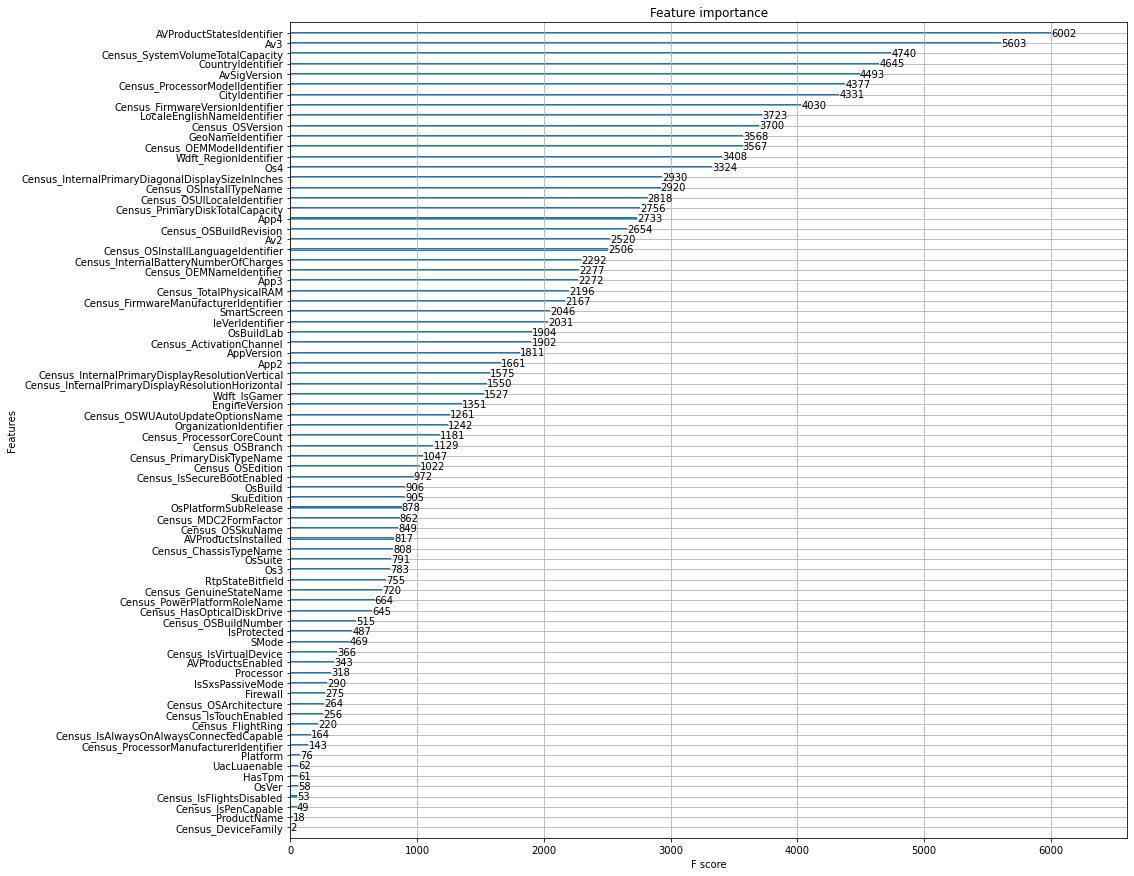

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(15,15))
xgb.plot_importance(clf_xgb0,ax=ax)

In [ ]:
testdata=pd.read_csv('/content/drive/My Drive/malware-detection-va/test_to_give.csv')
testdata

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,6810c5d22b0973b53a89ef881656e192,win8defender,1.1.14405.2,4.11.15063.1155,1.259.725.0,0,7.0,0,3000.0,7945.0,2.0,1.0,1,159,77866.0,27.0,194.0,75,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,NaN,108.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1443.0,256480.0,4.0,5.0,...,953869.0,HDD,239169.0,0,6144.0,Laptop,15.5,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.15063.1155,amd64,rs2_release,15063,1155,Core,CORE,Other,8.0,31,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,9321.0,1,NaN,0.0,0,0,0.0,0.0,11.0
1,4d810281c41ae85517e447146ec15b0a,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1232.0,0,7.0,0,NaN,7945.0,2.0,1.0,1,41,32657.0,27.0,52.0,217,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189457.0,2.0,5.0,...,476940.0,HDD,475950.0,0,4096.0,Notebook,15.5,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134,165,ProfessionalEducation,PROFESSIONAL,UUPUpgrade,9.0,34,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,0.0,556.0,63654.0,1,0.0,0.0,0,0,0.0,1.0,10.0
2,d0d7e4da90f95d04cdecc0143b690e0a,win8defender,1.1.15100.1,4.18.1807.18075,1.273.922.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,180,103309.0,NaN,233.0,210,windows10,x64,10.0.0.0,16299,256,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Pro,1.0,0,NaN,0.0,117.0,NaN,1.0,1.0,Desktop,Windows.Desktop,4589.0,313586.0,4.0,1.0,...,238475.0,SSD,237511.0,0,8192.0,Desktop,24.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.16299.547,amd64,rs3_release_svc_escrow,16299,547,Professional,PROFESSIONAL,Reset,30.0,128,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,9491.0,0,NaN,0.0,0,0,0.0,1.0,3.0
3,718b06bd3089b5a37c63ad6af86ee0cd,win8defender,1.1.15000.2,4.18.1806.18062,1.271.216.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,101,1873.0,27.0,129.0,126,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,0.0,117.0,RequireAdmin,1.0,1.0,AllInOne,Windows.Desktop,525.0,318973.0,2.0,5.0,...,953869.0,HDD,153600.0,0,4096.0,Desktop,19.4,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.16299.371,amd64,rs3_release,16299,371,Core,CORE,Update,19.0,74,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,142.0,2827.0,1,0.0

In [ ]:
machineid=testdata['MachineIdentifier']
testdata.drop(['DefaultBrowsersIdentifier','MachineIdentifier','PuaMode','Census_ProcessorClass','Census_InternalBatteryType','Census_IsFlightingInternal','Census_ThresholdOptIn',
'Census_IsWIMBootEnabled'],axis=1,inplace=True)

In [ ]:
catdatat=selectbytype(testdata,'object')
catdatasplit=split(catdatat.copy()).astype('int64')
catdatat=labelencode(catdatat.copy(),catdatat.columns)
catdatatfreq=frequencyencoding(catdatat.copy(),catdatat.columns)
catdatatfreq=pd.concat([catdatatfreq,catdatasplit],join='outer',axis=1)
catdatatfreq

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,App1,App2,App3,App4,Av1,Av2,Av3,Av4,Os1,Os2,Os3,Os4
0,1.0,0.010982,0.010297,0.001391,1.0,1.0,1.0,0.205182,0.207520,1.000000,0.697655,1.000000,1.0,1.000000,0.131256,1.000000,0.034385,1.0,0.210476,1.000000,1.000000,0.327245,0.536733,1.0,0.713072,1.0,4,11,15063,1155,1,259,725,0,10,0,15063,1155
1,1.0,0.874704,1.000000,0.061217,1.0,1.0,1.0,1.000000,1.000000,0.569401,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.603154,1.0,1.000000,0.014965,0.873406,1.000000,1.000000,1.0,1.000000,1.0,4,18,1807,18075,1,273,1232,0,10,0,17134,165
2,1.0,0.874704,1.000000,0.066087,1.0,1.0,1.0,0.663114,0.345209,0.569401,0.697655,0.332289,1.0,0.429988,0.345421,0.324892,0.245895,1.0,0.298941,0.858125,0.873406,0.251117,0.653113,1.0,1.000000,1.0,4,18,1807,18075,1,273,922,0,10,0,16299,547
3,1.0,0.083533,0.177617,0.008000,1.0,1.0,1.0,0.663114,0.279669,1.000000,1.000000,0.050069,1.0,1.000000,0.345421,0.324892,0.255758,1.0,0.336079,1.000000,1.000000,0.651612,0.653113,1.0,0.713072,1.0,4,18,1806,18062,1,271,216,0,10,0,16299,371
4,1.0,1.000000,1.000000,0.106783,1.0,1.0,1.0,1.000000,1.000000,0.569401,0.697655,0.332289,1.0,0.064937,0.345421,0.324892,1.000000,1.0,1.000000,0.858125,0.873406,0.000000,1.000000,1.0,1.000000,1.0,4,18,1807,18075,1,275,760,0,10,0,17134,228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243308,1.0,1.000000,1.000000,0.179826,1.0,1.0,1.0,0.663114,0.279669,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.120387,1.0,0.336079,1.000000,1.000000,0.651612,0.536733,1.0,1.000000,1.0,4,18,1807,18075,1,275,1555,0,10,0,16299,309
243309,1.0,0.083533,0.177617,0.114435,1.0,1.0,1.0,0.196607,0.055025,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.168780,1.0,0.211843,0.520147,0.520138,0.651612,0.536733,1.0,0.713072,1.0,4,18,1806,18062,1,271,1003,0,10,0,14393,2189
243310,1.0,1.000000,0.027681,0.910261,1.0,1.0,1.0,0.663114,0.279669,1.000000,0.697655,1.000000,1.0,1.000000,1.000000,1.000000,0.120387,1.0,0.336079,0.520147,0.520138,1.000000,0.653113,1.0,1.000000,1.0,4,12,17007,18022,1,275,727,0,10,0,16299,309
243311,1.0,1.000000,1.000000,0.323478,1.0,1.0,1.0,0.663114,0.345209,1.000000,1.000000,0.050069,1.0,1.000000,0.345421,0.324892,0.401236,1.0,0.298941,1.000000,1.000000,0.508772,0.653113,1.0,0.713072,1.0,4,18,1807,18075,1,275,1025,0,10,0,16299,431


In [ ]:
intdatat=selectbytype(testdata,'int64')
intdatat=scale(intdatat.copy(),intdatat.columns)
intdatat

,IsBeta,IsSxsPassiveMode,HasTpm,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,AutoSampleOptIn,Census_HasOpticalDiskDrive,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable
0,0,0,1,0.714932,0.262411,0.701278,0.979167,0,0,0.632145,0.060465,0.166667,0,1,0,0
1,0,0,1,0.180995,0.765957,0.895884,0.312500,0,0,0.871789,0.008638,0.185897,0,1,0,0
2,0,0,1,0.809955,0.741135,0.817422,0.312500,0,0,0.775168,0.028636,0.788462,0,0,0,0
3,0,0,1,0.452489,0.443262,0.817422,0.979167,0,0,0.775168,0.019422,0.442308,0,1,0,0
4,0,0,1,0.190045,0.145390,0.895884,0.312500,0,0,0.871789,0.011936,0.980769,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243308,0,0,1,0.221719,0.177305,0.817422,0.979167,0,0,0.775168,0.016176,0.096154,0,1,0,0
243309,0,0,1,0.253394,0.783688,0.638320,0.979167,0,0,0.554617,0.114595,0.192308,0,1,0,0
243310,0,0,1,0.633484,0.801418,0.817422,0.979167,0,0,0.775168,0.016176,0.185897,0,0,0,0
243311,0,0,1,0.918552,0.258865,0.817422,0.979167,0,1,0.775168,0.022563,0.166667,0,1,1,0


In [ ]:
floatdatat=selectbytype(testdata,'float64')
floatdatat.fillna(floatdatat.mean(),inplace=True)
floatdatat=scale(floatdatat.copy(),floatdatat.columns)
floatdatat

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSInstallLanguageIdentifier,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,0.875,0.112226,0.25,0.2,0.463595,0.509804,0.654237,1.0,0.000634,0.250000,1.0,0.020833,0.228928,0.742348,0.031579,0.444444,0.537391,0.100012,0.025078,0.010753,0.104742,0.132448,0.200208,0.000000,0.184211,0.000000,0.320896,0.128972,0.0,0.000000,0.0,0.714286
1,0.875,0.112226,0.25,0.2,0.194408,0.509804,0.172881,1.0,0.000000,0.317757,1.0,0.020833,0.088226,0.548358,0.010526,0.444444,0.451830,0.050007,0.049906,0.006843,0.104742,0.132448,0.200208,0.000000,0.210526,0.000000,0.508396,0.882948,0.0,0.000000,1.0,0.642857
2,0.875,0.758130,0.00,0.2,0.615091,0.467755,0.786441,1.0,0.000000,0.271028,1.0,0.020833,0.744834,0.907635,0.031579,0.000000,0.239389,0.025004,0.024904,0.014663,0.164897,0.186125,0.281437,1.000000,0.763158,0.000000,0.122201,0.131331,0.0,0.000000,1.0,0.142857
3,0.875,0.758130,0.00,0.2,0.011111,0.509804,0.433898,1.0,0.000000,0.271028,1.0,0.020833,0.078386,0.923227,0.010526,0.444444,0.443072,0.100012,0.016106,0.006843,0.132343,0.186125,0.281437,1.000000,0.473684,0.000000,0.122201,0.038855,0.0,0.000000,0.0,0.571429
4,0.875,0.758130,0.00,0.2,0.856245,0.333333,0.176271,1.0,0.000000,0.317757,1.0,0.020833,0.429813,0.741523,0.030636,0.391523,0.525309,0.052434,0.039172,0.010323,0.157820,0.186125,0.281437,0.255888,0.947368,0.000013,0.369233,0.458044,0.0,0.066615,0.0,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243308,0.875,0.758130,0.00,0.2,0.686435,0.467755,0.227119,1.0,0.000000,0.257009,1.0,0.020833,0.354051,0.579455,0.031579,0.444444,0.509544,0.050007,0.048250,0.006843,0.104742,0.132448,0.200208,0.000000,0.052632,0.000000,0.506530,0.459563,0.0,0.000000,1.0,0.142857
243309,0.875,0.867730,0.25,0.2,0.336090,0.333333,0.254237,0.0,0.000000,0.226636,1.0,0.020833,0.336996,0.701858,0.010526,0.444444,0.444419,0.050007,0.048106,0.006843,0.093418,0.132448,0.200208,0.000000,0.236842,0.000000,0.506530,0.458314,0.0,0.000000,0.0,0.642857
243310,0.875,0.758130,0.00,0.2,0.571898,0.921569,0.562712,1.0,0.000000,0.257009,1.0,0.020833,0.728600,0.890511,0.031579,0.444444,0.514485,0.075009,0.074867,0.010753,0.093418,0.132448,0.200208,0.000000,0.210526,0.000000,0.508396,0.792609,0.0,0.000000,0.0,0.642857
243311,0.875,0.758130,0.00,0.2,0.483292,0.509804,0.867797,1.0,0.000000,0.271028,1.0,0.020833,0.336996,0.291186,0.031579,0.444444,0.581406,0.100012,0.098613,0.010753,0.157820,0.186125,0.281437,1.000000,0.184211,0.000000,0.076493,0.274416,0.0,0.000000,0.0,0.714286


In [ ]:
test=pd.concat([catdatatfreq,intdatat,floatdatat],join='outer',axis=1)
test

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,App1,App2,App3,App4,Av1,Av2,Av3,Av4,Os1,Os2,Os3,Os4,IsBeta,IsSxsPassiveMode,...,Census_HasOpticalDiskDrive,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSInstallLanguageIdentifier,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,1.0,0.010982,0.010297,0.001391,1.0,1.0,1.0,0.205182,0.207520,1.000000,0.697655,1.000000,1.0,1.000000,0.131256,1.000000,0.034385,1.0,0.210476,1.000000,1.000000,0.327245,0.536733,1.0,0.713072,1.0,4,11,15063,1155,1,259,725,0,10,0,15063,1155,0,0,...,0,0.632145,0.060465,0.166667,0,1,0,0,0.875,0.112226,0.25,0.2,0.463595,0.509804,0.654237,1.0,0.000634,0.250000,1.0,0.020833,0.228928,0.742348,0.031579,0.444444,0.537391,0.100012,0.025078,0.010753,0.104742,0.132448,0.200208,0.000000,0.184211,0.000000,0.320896,0.128972,0.0,0.000000,0.0,0.714286
1,1.0,0.874704,1.000000,0.061217,1.0,1.0,1.0,1.000000,1.000000,0.569401,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.603154,1.0,1.000000,0.014965,0.873406,1.000000,1.000000,1.0,1.000000,1.0,4,18,1807,18075,1,273,1232,0,10,0,17134,165,0,0,...,0,0.871789,0.008638,0.185897,0,1,0,0,0.875,0.112226,0.25,0.2,0.194408,0.509804,0.172881,1.0,0.000000,0.317757,1.0,0.020833,0.088226,0.548358,0.010526,0.444444,0.451830,0.050007,0.049906,0.006843,0.104742,0.132448,0.200208,0.000000,0.210526,0.000000,0.508396,0.882948,0.0,0.000000,1.0,0.642857
2,1.0,0.874704,1.000000,0.066087,1.0,1.0,1.0,0.663114,0.345209,0.569401,0.697655,0.332289,1.0,0.429988,0.345421,0.324892,0.245895,1.0,0.298941,0.858125,0.873406,0.251117,0.653113,1.0,1.000000,1.0,4,18,1807,18075,1,273,922,0,10,0,16299,547,0,0,...,0,0.775168,0.028636,0.788462,0,0,0,0,0.875,0.758130,0.00,0.2,0.615091,0.467755,0.786441,1.0,0.000000,0.271028,1.0,0.020833,0.744834,0.907635,0.031579,0.000000,0.239389,0.025004,0.024904,0.014663,0.164897,0.186125,0.281437,1.000000,0.763158,0.000000,0.122201,0.131331,0.0,0.000000,1.0,0.142857
3,1.0,0.083533,0.177617,0.008000,1.0,1.0,1.0,0.663114,0.279669,1.000000,1.000000,0.050069,1.0,1.000000,0.345421,0.324892,0.255758,1.0,0.336079,1.000000,1.000000,0.651612,0.653113,1.0,0.713072,1.0,4,18,1806,18062,1,271,216,0,10,0,16299,371,0,0,...,0,0.775168,0.019422,0.442308,0,1,0,0,0.875,0.758130,0.00,0.2,0.011111,0.509804,0.433898,1.0,0.000000,0.271028,1.0,0.020833,0.078386,0.923227,0.010526,0.444444,0.443072,0.100012,0.016106,0.006843,0.132343,0.186125,0.281437,1.000000,0.473684,0.000000,0.122201,0.038855,0.0,0.000000,0.0,0.571429
4,1.0,1.000000,1.000000,0.106783,1.0,1.0,1.0,1.000000,1.000000,0.569401,0.697655,0.332289,1.0,0.064937,0.345421,0.324892,1.000000,1.0,1.000000,0.858125,0.873406,0.000000,1.000000,1.0,1.000000,1.0,4,18,1807,18075,1,275,760,0,10,0,17134,228,0,0,...

In [ ]:
prediction=pd.DataFrame(modelgb.predict_proba(test))
prediction

,0,1
0,0.917661,0.082339
1,0.934351,0.065649
2,0.808246,0.191754
3,0.906280,0.093720
4,0.859220,0.140780
...,...,...
243308,0.842549,0.157451
243309,0.924396,0.075604
243310,0.837439,0.162561
243311,0.846218,0.153782


In [ ]:
pre=pd.DataFrame()
pre['MachineIdentifier']=machineid
pre['HasDetections']=prediction.loc[:,1]
pre

,MachineIdentifier,HasDetections
0,6810c5d22b0973b53a89ef881656e192,0.082339
1,4d810281c41ae85517e447146ec15b0a,0.065649
2,d0d7e4da90f95d04cdecc0143b690e0a,0.191754
3,718b06bd3089b5a37c63ad6af86ee0cd,0.093720
4,4ab7e3633628cccb65e055d91979c31b,0.140780
...,...,...
243308,5426568056581385156f6c57eb1c16b7,0.157451
243309,4d05c57f5fa2177e4463b1d93adb9282,0.075604
243310,6aa49e8161838cca6b0584a18c45f016,0.162561
243311,690d6524746bb857e27876471a649176,0.153782


In [ ]:
pre.to_csv('pre.csv',index=False)